In [64]:
import cmocean.cm as cmo
import salem

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import wrf

In [65]:
def calc_q(RH, T2M):
    """Calculate specific humidity (q) in g/kg."""
    p = 101300
    t2 = T2M - 273.13
    exponent = 7.5 * t2 / (t2 - 237.3)  #
    e = (RH / 100) * 610.7 * 10**exponent
    q = ((0.622 * e) / p) * 1000
    return q

In [70]:
ax_options = {
    "color": "black",
    "linestyle": "dotted",
    "linewidth": 0.5,
    "zorder": 103,
    "draw_labels": True,
    "x_inline": False,
    "y_inline": False,
}
title_options = {
    "loc": "left",
    "fontsize": "x-large",
    "fontweight": "bold",
}


def get_extent(variable):
    return [
        variable.lon.min(),
        variable.lon.max(),
        variable.lat.min(),
        variable.lat.max(),
    ]


def side_by_side_plot(variables, titles, unit):
    fig = plt.figure(figsize=(15, 5))

    for i, (variable, title) in enumerate(zip(variables, titles)):
        ax = fig.add_subplot(1, 2, i, projection=ccrs.PlateCarree())

        gl = ax.gridlines(**ax_options)
        gl.right_labels = False
        gl.top_labels = False
        ax.set_extent(get_extent(variable))
        ax.coastlines(linewidth=1.0, resolution="10m")
        colormesh = ax.pcolormesh(
            variable.lon,
            variable.lat,
            variable,
            vmin=0,
            vmax=35,
            cmap=cmo.thermal,
            transform=ccrs.PlateCarree(),
        )
        fig.colorbar(
            colormesh,
            orientation="horizontal",
            fraction=0.09,
            pad=0.1,
            label=unit,
            ax=ax,
        )

        ax.set_title(title, **title_options)

    return fig


def plot_difference(variables, titles, unit):
    assert len(variables) == 2, "Length of `variables` should equal 2"
    assert len(variables) == 2, "Length of `titles` should equal 2"
    diff = variables[1] - variables[0]
    title = f"{titles[1]} - {titles[0]}"

    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    gl = ax.gridlines(**ax_options)
    gl.right_labels = False
    gl.top_labels = False
    ax.set_extent(get_extent(diff))
    colormesh = ax.pcolormesh(
        diff.lon,
        diff.lat,
        diff,
        vmin=-5,
        vmax=5,
        cmap="bwr",
        transform=ccrs.PlateCarree(),
    )
    ax.coastlines(linewidth=1.0, resolution="10m")
    ax.set_title(title, **title_options)
    fig.colorbar(
        colormesh,
        orientation="horizontal",
        fraction=0.09,
        pad=0.1,
        label=unit,
        ax=ax,
    )

    return fig


# Open file
def get_q_from_wrfout_file(filename):
    wur_file = salem.open_wrf_dataset(filename)

    # Extract variables to calculate RH and calculate RH
    wur_q2 = wur_file.Q2.isel(time=34)
    wur_t2 = wur_file.T2.isel(time=34)
    wur_psfc = wur_file.PSFC.isel(time=34)

    wur_rh = wrf.rh(wur_q2, wur_psfc, wur_t2)

    # Calculate q
    wur_q = calc_q(wur_rh, wur_t2)
    return wur_q


variables = [
    get_q_from_wrfout_file("./wur_lcz/wrfout_d04_2019-07-23_06:00:00.nc"),
    get_q_from_wrfout_file("./wur/wrfout_d04_2019-07-23_06:00:00.nc"),
]
titles = [
    "CGLC-MODIS-LCZ",
    "Summer in the City",
]
unit = ("Specific Humidity (g/kg)",)

side_by_side_plot(variables, titles, unit)
plot_difference(variables, titles, unit)

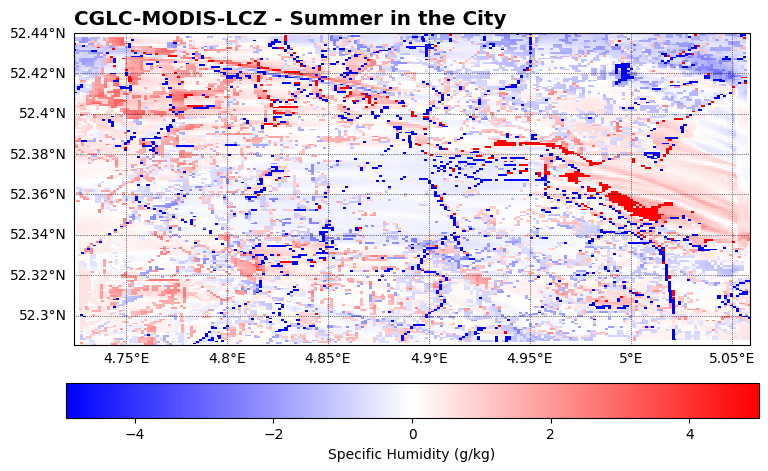